In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image


class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

original_img = load_image("/kaggle/input/sample/original.jpg")
style_img = load_image("/kaggle/input/sample/styles.jpg")

generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()

# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, "generated.png")

tensor(1315480.1250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(51574.5508, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24629.1758, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14371.9863, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8375.5986, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5196.4468, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3741.6299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2996.9778, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2511.6174, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [35]:
def show_images(original, style, generated):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for ax, image, title in zip(axs, [original, style, generated], ['Original Image', 'Style Image', 'Generated Image']):
        ax.imshow(np.transpose(image.cpu().detach().numpy(), (1, 2, 0)))
        ax.set_title(title)
        ax.axis('off')
    plt.show()

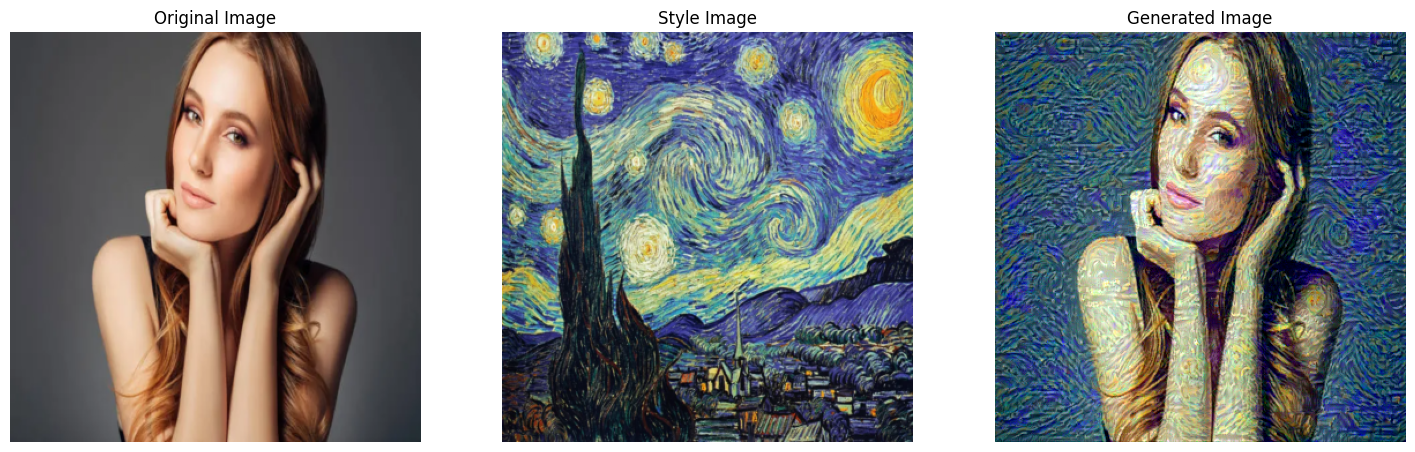

In [36]:
import matplotlib.pyplot as plt
show_images(original_img[0], style_img[0], generated[0])